Analysis of recent coronavirus data for different countries and regions.  
Author: Javier Moldon  
More info in https://github.com/jmoldon/coronavirus_analysis

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates
from IPython.display import display, Markdown


In [2]:
matplotlib.rcParams["figure.figsize"] = 20,9
import warnings
warnings.filterwarnings('ignore')
do_debug = False

# General statistics

Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily.

In [3]:
# import data from github url, url1 -Confirmed, url2 -Deaths. url3 -Recovered
data_path = './data/'
file1 = data_path + 'time_series_19-covid-Confirmed.csv'
file2 = data_path + 'time_series_19-covid-Deaths.csv'
file3 = data_path + 'time_series_19-covid-Recovered.csv'

df1 = pd.read_csv(file1, error_bad_lines=False)
df2 = pd.read_csv(file2, error_bad_lines=False)
df3 = pd.read_csv(file3, error_bad_lines=False)

#display(df1.head(), df2.head(), df3.head())

In [4]:
# Convert date columns to a time series
df1u = pd.melt(df1, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Confirmed')
df2u = pd.melt(df2, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Deaths')
df3u = pd.melt(df3, id_vars=['Province/State', 'Country/Region', 'Lat','Long'], var_name='DateTime', value_name='Recovered')

df1u['DateTime'] = pd.to_datetime(df1u['DateTime'])
df2u['DateTime'] = pd.to_datetime(df2u['DateTime'])
df3u['DateTime'] = pd.to_datetime(df3u['DateTime'])

data = pd.concat([df1u, df2u, df3u], axis=1, join='inner')
data = data.loc[:,~data.columns.duplicated()] # Remove columns that were repeated in the three datasets
data['Active'] = data['Confirmed']-data['Deaths']-data['Recovered']
data['mortality_fraction'] = data['Deaths']/data['Confirmed']
data['Province/State'][data['Province/State'].isna()] = ''

In [5]:
#Example table:
#data[['Country/Region','Confirmed','Deaths','Recovered']]

In [6]:
#I need to remove a few points manually that I identified as bad ones
data.drop(data[(data['Country/Region']=='Spain') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Italy') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='Netherlands') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-13', '%Y-%m-%d'))].index, inplace=True)
data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-15', '%Y-%m-%d'))].index, inplace=True)

## List of most affected countries (sorted by number of confirmed cases)

In [7]:
data.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Confirmed')[::-1][0:20]

,,Confirmed,Deaths,Recovered
Country/Region,Province/State,,,
China,Hubei,67798,3099,55142
Italy,,27980,2158,2749
Iran,,14991,853,4590
Spain,,9942,342,530
"Korea, South",,8236,75,1137
Germany,,7272,17,67
France,France,6633,148,12
Switzerland,,2200,14,4
United Kingdom,United Kingdom,1543,55,20


## List of most affected countries/provinces (sorted by number of deaths)

In [8]:
data.groupby(['Country/Region', 'Province/State'])[['Confirmed', 'Deaths', 'Recovered']].max().sort_values(by='Deaths')[::-1][0:20]

,,Confirmed,Deaths,Recovered
Country/Region,Province/State,,,
China,Hubei,67798,3099,55142
Italy,,27980,2158,2749
Iran,,14991,853,4590
Spain,,9942,342,530
France,France,6633,148,12
"Korea, South",,8236,75,1137
United Kingdom,United Kingdom,1543,55,20
US,Washington,904,48,1
Japan,,839,27,144


# Evolution of cases (Confirmed, Deaths, Active and Recovery) per country

All plots have the same information. Left: log scale, right: linear scale. Bottom-right: is a zoom to show the correct scale for deaths. The straight line is a fit to a logistic growth when possible. If the fit does not converge (low number of points in early stages) a simple exponential is used. The dashed line is a prediction based on the fit. 

In [9]:
def select_country(data, country='', province='', start_date='2020-01-01', end_date='2021-12-31'):
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    # Select by province
    if province != '':
        cond2 = data['Province/State'] == province
    else:
        cond2 = data['Province/State'] != np.nan  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    selection = cond1&cond2&cond3
    if do_debug:
        print('Number of entries per country: {}'.format(cond1.sum()))
        print('Number of entries per province: {}'.format(cond2.sum()))
        print('Number of entries per time range: {}'.format(cond3.sum()))
        print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

In [10]:
def plot_country(data_country, prediction):
    gridsize = (3, 2)
    fig = plt.figure(figsize=(18, 8))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=3)
    ax2 = plt.subplot2grid(gridsize, (0, 1), rowspan=2)
    ax3 = plt.subplot2grid(gridsize, (2, 1))
    plt.subplots_adjust(hspace=0)

    colors = {'Confirmed': '#3498db',
              'Deaths': 'tomato',
              'Recovered': 'g',
               'Active': 'k'}
    for ax in [ax1,ax2,ax3]:
        ax.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color=colors['Confirmed'], label='Confirmed')
        ax.plot(data_country['DateTime'], data_country['Deaths'],    'o', color=colors['Deaths'], label='Deaths')
        ax.plot(data_country['DateTime'], data_country['Recovered'], 'o', color=colors['Recovered'], label='Recovered')
        ax.plot(data_country['DateTime'], data_country['Active'],    'o', color=colors['Active'], label='Active')    
        ax.plot(data_country['DateTime'], data_country['Recovered_fit'], '-', color=colors['Recovered'])
        ax.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color=colors['Confirmed'])
        ax.plot(data_country['DateTime'], data_country['Deaths_fit'],    '-', color=colors['Deaths'])
        # Model and prediction
        for column in ['Confirmed', 'Deaths', 'Recovered']:
            ax.plot(prediction['DateTime'], prediction[column+'_pred'], '--', color=colors[column])
            ax.fill_between(prediction['DateTime'], prediction[column+'_pred_upper'], prediction[column+'_pred_lower'], color=colors[column], alpha=0.5)
    # Active
    active_fit = data_country['Confirmed_fit']-data_country['Recovered_fit']-data_country['Deaths_fit']
    active_pred = prediction['Confirmed_pred']-prediction['Recovered_pred']-prediction['Deaths_pred']    
    for ax in [ax1,ax2,ax3]:
        ax.plot(data_country['DateTime'], active_fit,                '-', color=colors['Active'])    
        ax.plot(prediction['DateTime'], active_pred, '--', color=colors['Active'])

    ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    ax1.set_ylim(2,1e5)

    ax1.set_ylabel('Number of cases (log scale)')
    ax2.set_ylabel('Number of cases (linear scale)')
    ax3.set_ylabel('Zoom')
    
    ax1.xaxis.set_tick_params(rotation=45)
    ax2.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax1.grid()
    
    country = data_country['Country/Region'].unique()[0]
    province = data_country['Province/State'].unique()[0]
    start_date = data_country['DateTime'].iloc[0]
    end_date = data_country['DateTime'].iloc[-1]
    fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    
    ax1.legend()
    ax2.legend()
    ax3.legend()
    ax = [ax1,ax2,ax3]
    fig.savefig(f'./plots/{country}{province}.png', bbox_inches='tight', dpi=150)
    return fig, ax

In [33]:
# Functions to fit models to the data, including predictions and confidence interval

# For few data points, the exponential benefits from fixing the reference data.
# I could use x[0], but then I cannot compute the upper/lower bounds for each data
# point using the same model, so I fix t0
t0 = 737476.0

def func_exponential(x,  b, alpha):
    return  b * np.exp(alpha * (x-t0))

def func_logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def calc_goodness(x, y, func, popt):
    # residual sum of squares
    y_fit = func(x, *popt)
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def read_fit(popt, pcov, x, y, func, name):
    fit = {}
    fit['popt'] = popt
    fit['pcov'] = pcov
    fit['popt_err'] = np.sqrt(np.diag(pcov))
    fit['goodness'] = calc_goodness(x,y,func,popt)
    fit['func'] = func
    fit['name'] = name
    return fit
    
def choose_optimal_fit(fits):
    fit_names = fits.keys()
    best_goodness = -9999
    for name in fit_names:
        if fits[name]['goodness'] > best_goodness:
            best_goodness = fits[name]['goodness']
            best_fit = fits[name]
    return best_fit

def calc_ci(popt, pcov, xx, func, N=1000):
    popt_err = np.sqrt(np.diagonal(pcov))
    params_sim = np.empty((len(popt), N))
    for i, (p, p_err) in enumerate(zip(popt, popt_err)):
        params_sim[i] = np.random.normal(p, p_err, N)
    y_err = np.empty_like(xx)
    upper_bound = np.empty_like(xx)
    lower_bound = np.empty_like(xx)
    for i, xi in enumerate(xx):
        y_err[i] = np.std(func(xi, *params_sim))
        upper_bound[i] = func(xi, *popt) + y_err[i]
        lower_bound[i] = func(xi, *popt) - y_err[i]
    return upper_bound, lower_bound, y_err

def print_best_fit(best_fit):
    print()
    print('best', best_fit['name'], best_fit['goodness'])
    print('popt     ', best_fit['popt'])
    print('popt_err ', best_fit['popt_err'])
    print('popt_err/popt ', best_fit['popt_err']/best_fit['popt'])

def fit_data(data, future_d=5, fits_todo={}, p0={}, min_y={}, threshold={}):
    if fits_todo == {}:
        fits_todo = {'Confirmed': [func_exponential, func_logistic],
                     'Deaths':    [func_exponential, func_logistic],
                     'Recovered': [func_exponential, func_logistic]
                    }
    if min_y == {}:
        min_y = {'Confirmed': 20,
                 'Deaths': 2,
                 'Recovered': 5
                }
    x = mdates.date2num(data['DateTime'])
    # Prepare dates for prediction that will go to the "prediction" dataframe
    dates_pred = pd.date_range(start=data['DateTime'].iloc[0], end=data['DateTime'].iloc[-1]+datetime.timedelta(days=future_d))
    prediction = pd.DataFrame({'DateTime':dates_pred})
    xx = mdates.date2num(dates_pred)
    for column in fits_todo.keys():
        if do_debug: print('\nColumn: ',column)
        y = data[column].values
        my_fits = {}
        cond = data[column] > min_y[column]
        # The default parameter guessing depends on the data, y
        p_guess_default = {func_exponential: [np.max(y), 0.3],
                           func_logistic:    [np.max(y), 0.3, np.mean(x)]}
        if do_debug: print('p_guess_default: ', p_guess_default)
        for func in fits_todo[column]:
            name = func.__name__
            # Compute some initial guessings per function
            if column in p0.keys():
                pguess = p0[column].get(func, p_guess_default[func])
            else:
                pguess = p_guess_default[func]
            if do_debug: print('pguess ', pguess)
            try:            
                popt, pcov = curve_fit(func, x, y, p0=pguess)
                my_fits[name] = read_fit(popt, pcov, x[cond], y[cond], func, name)
                if do_debug: print(my_fits[name])
            except RuntimeError:
                if do_debug: print(f'Fit {name} did not converge')
        if any([v['goodness']>0. for k,v in my_fits.items()]): # Means at least one fit was successful
            best_fit = choose_optimal_fit(my_fits)
            if do_debug:
                print_best_fit(best_fit)
            # Fill main dataframe with best fit
            data.loc[:, column+'_fit'] = best_fit['func'](x, *best_fit['popt'])
            # Fill prediction with best fit prediction
            upper_bound, lower_bound, y_err = calc_ci(best_fit['popt'], best_fit['pcov'], xx, best_fit['func'])
            prediction[column+'_pred'] = best_fit['func'](xx, *best_fit['popt'])
            prediction[column+'_pred_upper'] = upper_bound
            prediction[column+'_pred_lower'] = lower_bound
            # With low number of data points the error can be huge, I will remove the
            # confidence interval when any of the fitted parameters have huge errors:
            bound_threshold = threshold.get(column, 0.6)
            if ((best_fit['popt_err']/best_fit['popt']) > bound_threshold).any():
                prediction[column+'_pred_upper'] *= np.nan
                prediction[column+'_pred_lower'] *= np.nan
        else:  # Could not find any solution
            data.loc[:, column+'_fit'] = np.nan
            prediction[column+'_pred'] = np.nan
            prediction[column+'_pred_upper'] = np.nan
            prediction[column+'_pred_lower'] = np.nan
    return data, prediction

#display(Markdown("$y(t)=\\frac{L}{1+ e^{-k(t-t0)}}$"))

In [12]:
def print_prediction(prediction, days=5):
    to_show = prediction[['DateTime', 'Confirmed_pred', 'Deaths_pred', 'Recovered_pred']][-days:]
    to_show['DateTime'] = to_show['DateTime'].dt.strftime('%A %d %B %Y')
    to_show.columns = ['Date (end of)', 'Confirmed', 'Deaths', 'Recovered']
    display(Markdown(f"#### {days} day prediction"))
    display(to_show.style.format({'Confirmed':"{:.0f}", 'Deaths':"{:.0f}", 'Recovered':"{:.0f}"}))

In [13]:
def process_country(data, country='Spain', province='', start_date='2020-02-15', end_date='2021-03-12'):
    my_country = select_country(data, country=country, province=province, start_date=start_date, end_date=end_date)
    data_country, prediction = fit_data(my_country)
    fig, ax = plot_country(data_country, prediction)
    return data_country, prediction, fig, ax


# Europe

## Spain

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
25,Tuesday 17 March 2020,13785,513,831
26,Wednesday 18 March 2020,18330,722,1113
27,Thursday 19 March 2020,24374,1017,1491
28,Friday 20 March 2020,32410,1432,1998
29,Saturday 21 March 2020,43095,2016,2676


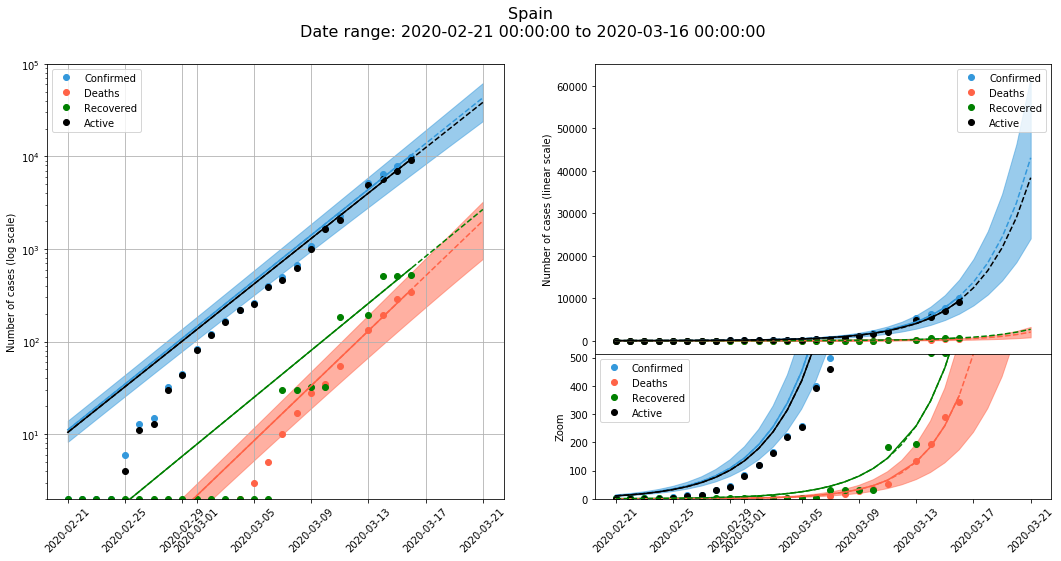

In [39]:
display(Markdown("## Spain"))
min_y1 = {'Confirmed': 100, 'Deaths': 10, 'Recovered': 10}
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8}

my_country = select_country(data, country='Spain', start_date='2020-02-21')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Italy

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
25,Tuesday 17 March 2020,31803,2446,3391
26,Wednesday 18 March 2020,35570,2746,4127
27,Thursday 19 March 2020,39279,3020,5023
28,Friday 20 March 2020,42841,3261,6113
29,Saturday 21 March 2020,46182,3466,7439


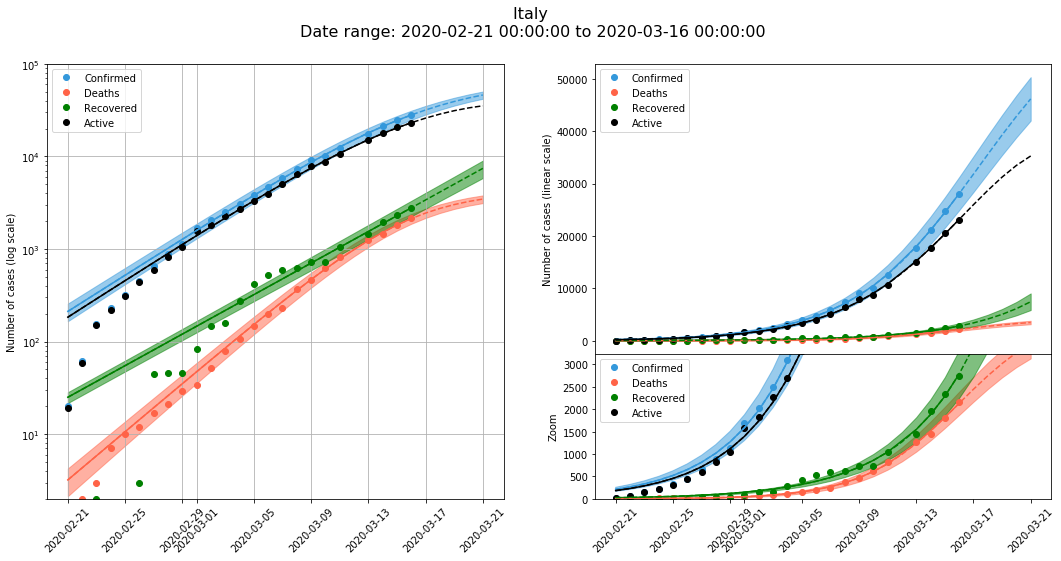

In [15]:
display(Markdown("## Italy"))
min_y1 = {'Confirmed': 10, 'Deaths': 1, 'Recovered': 5}

my_country = select_country(data, country='Italy', start_date='2020-02-21')
data_country, prediction = fit_data(my_country, min_y = min_y1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## France

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
24,Tuesday 17 March 2020,8107,182,14
25,Wednesday 18 March 2020,10171,234,14
26,Thursday 19 March 2020,12759,301,14
27,Friday 20 March 2020,16006,387,15
28,Saturday 21 March 2020,20080,498,15


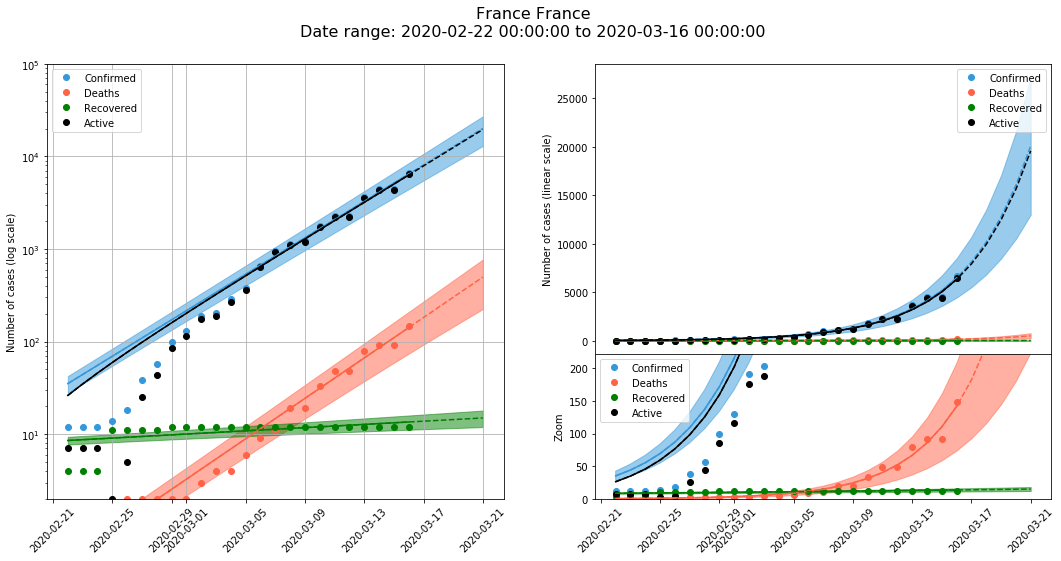

In [45]:
display(Markdown("## France"))
min_y1 = {'Confirmed': 50, 'Deaths': 10, 'Recovered': 2}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

threshold1 = {'Confirmed': 0.9, 'Deaths': 0.9}
my_country = select_country(data, country='France',province='France', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Germany

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
24,Tuesday 17 March 2020,9621,24,57
25,Wednesday 18 March 2020,12499,35,62
26,Thursday 19 March 2020,16240,50,69
27,Friday 20 March 2020,21099,71,75
28,Saturday 21 March 2020,27413,102,83


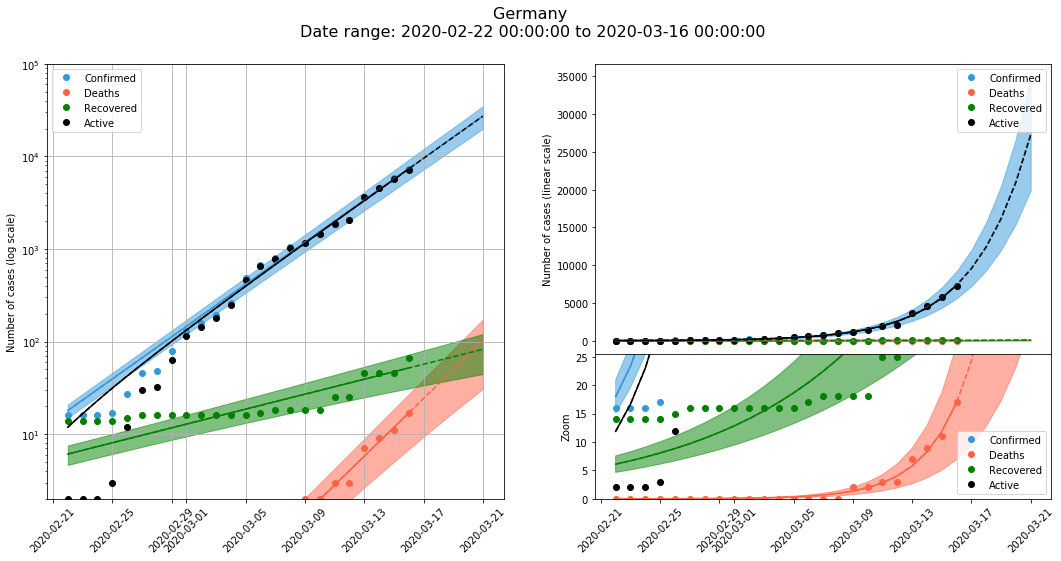

In [49]:
display(Markdown("## Germany"))
min_y1 = {'Confirmed': 50, 'Deaths': 2, 'Recovered': 1}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8}

my_country = select_country(data, country='Germany',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## United Kingdom

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
24,Tuesday 17 March 2020,2014,82,23
25,Wednesday 18 March 2020,2535,124,24
26,Thursday 19 March 2020,3190,187,26
27,Friday 20 March 2020,4014,282,27
28,Saturday 21 March 2020,5051,425,29


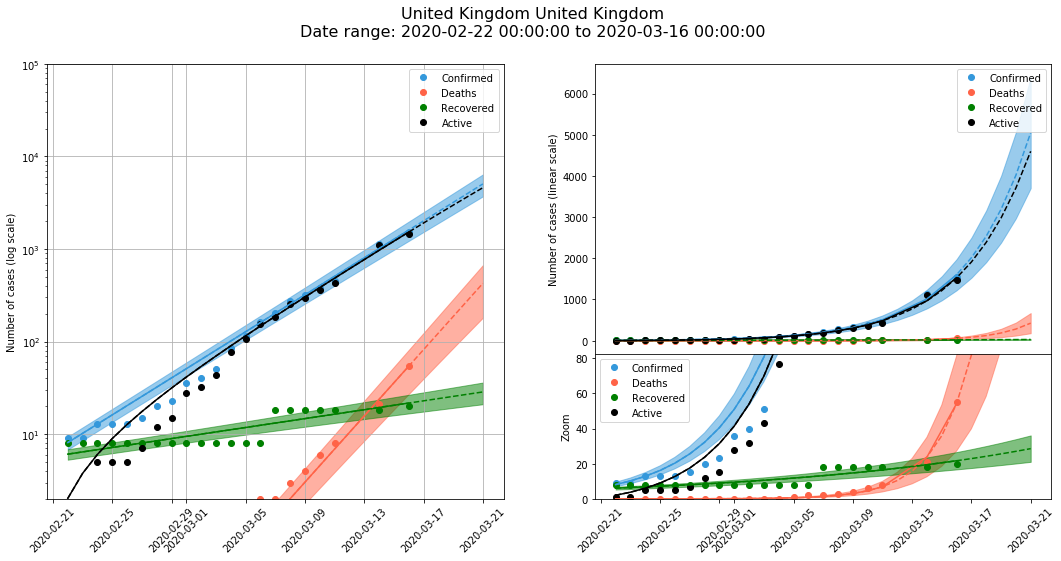

In [18]:
display(Markdown("## United Kingdom"))
min_y1 = {'Confirmed': 50, 'Deaths': 2, 'Recovered': 1}

fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

my_country = select_country(data, country='United Kingdom',province='United Kingdom', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Sweden

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
24,Tuesday 17 March 2020,1194,10,nan
25,Wednesday 18 March 2020,1245,17,nan
26,Thursday 19 March 2020,1280,30,nan
27,Friday 20 March 2020,1305,52,nan
28,Saturday 21 March 2020,1321,89,nan


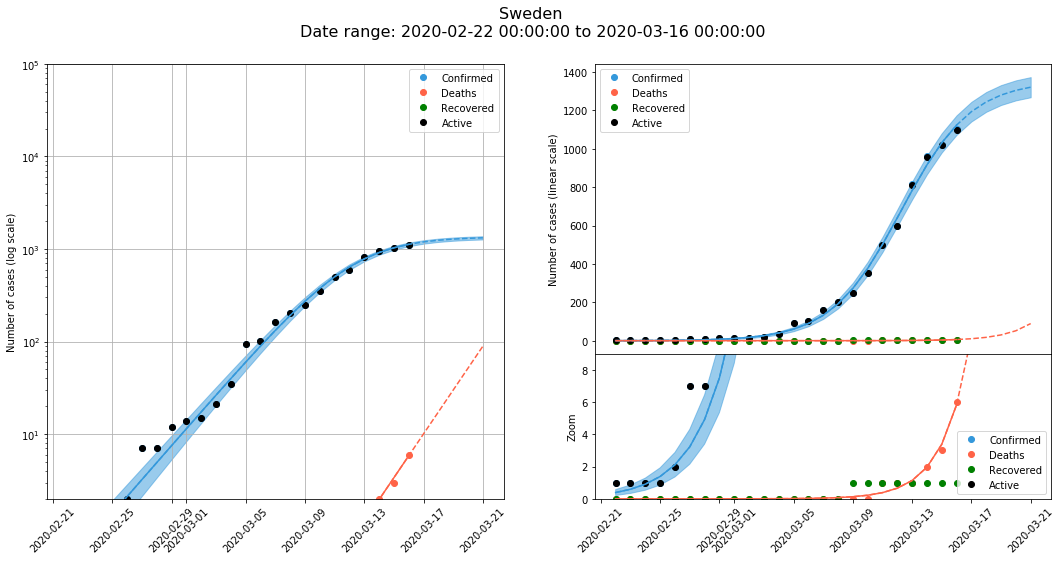

In [51]:
display(Markdown("## Sweden"))
min_y1 = {'Confirmed': 50, 'Deaths': 0, 'Recovered': 0}

fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic],
             'Recovered':  [func_exponential, func_logistic]}
threshold1 = {'Confirmed': 0.6, 'Deaths': 0.6}

my_country = select_country(data, country='Sweden',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

## Netherlands

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
24,Tuesday 17 March 2020,1816,34,nan
25,Wednesday 18 March 2020,2274,46,nan
26,Thursday 19 March 2020,2848,63,nan
27,Friday 20 March 2020,3566,86,nan
28,Saturday 21 March 2020,4465,117,nan


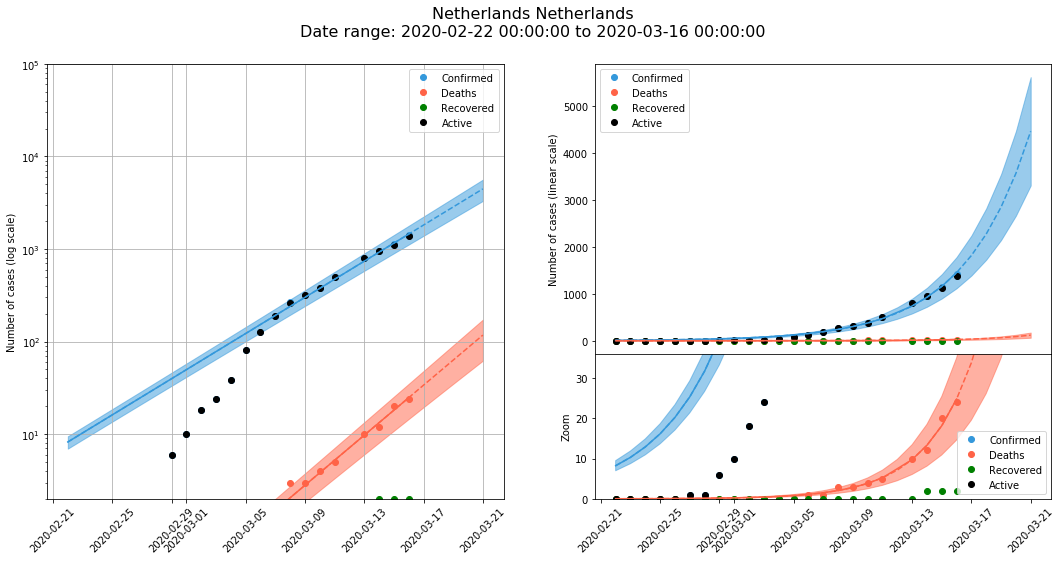

In [52]:
display(Markdown("## Netherlands"))
min_y1 = {'Confirmed': 10, 'Deaths': 4, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Netherlands',province='Netherlands', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)


## Poland

#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
24,Tuesday 17 March 2020,247,6,nan
25,Wednesday 18 March 2020,344,9,nan
26,Thursday 19 March 2020,479,13,nan
27,Friday 20 March 2020,667,18,nan
28,Saturday 21 March 2020,929,27,nan


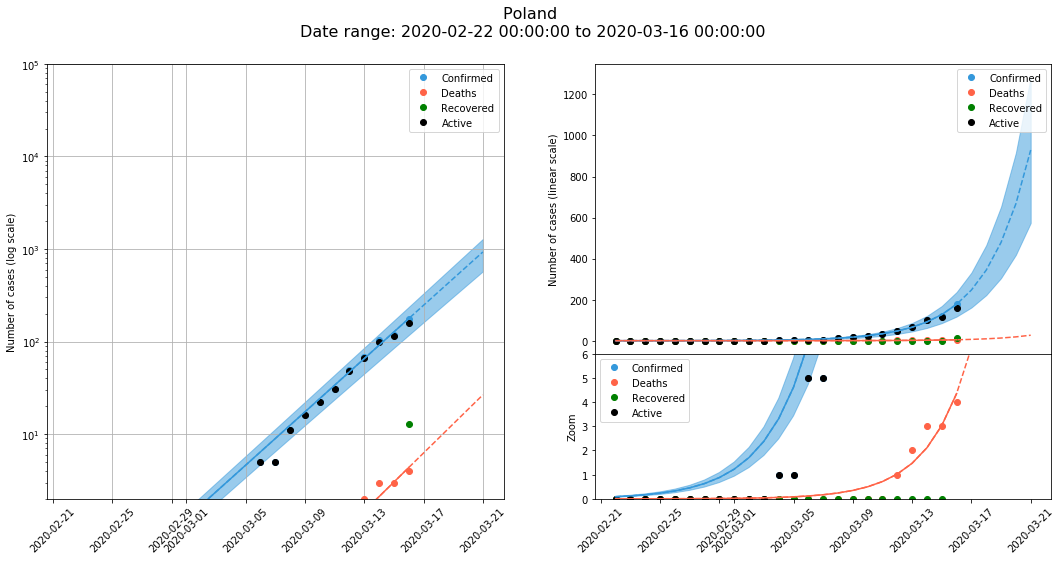

In [21]:
display(Markdown("## Poland"))
min_y1 = {'Confirmed': 10, 'Deaths': 1, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Poland',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)


# United States

I use the combined data for all the states combined

<class 'pandas._libs.tslibs.timestamps.Timestamp'>


#### 5 day prediction

,Date (end of),Confirmed,Deaths,Recovered
21,Tuesday 17 March 2020,6058,98,14
22,Wednesday 18 March 2020,7909,118,15
23,Thursday 19 March 2020,10326,142,15
24,Friday 20 March 2020,13480,170,16
25,Saturday 21 March 2020,17598,205,17


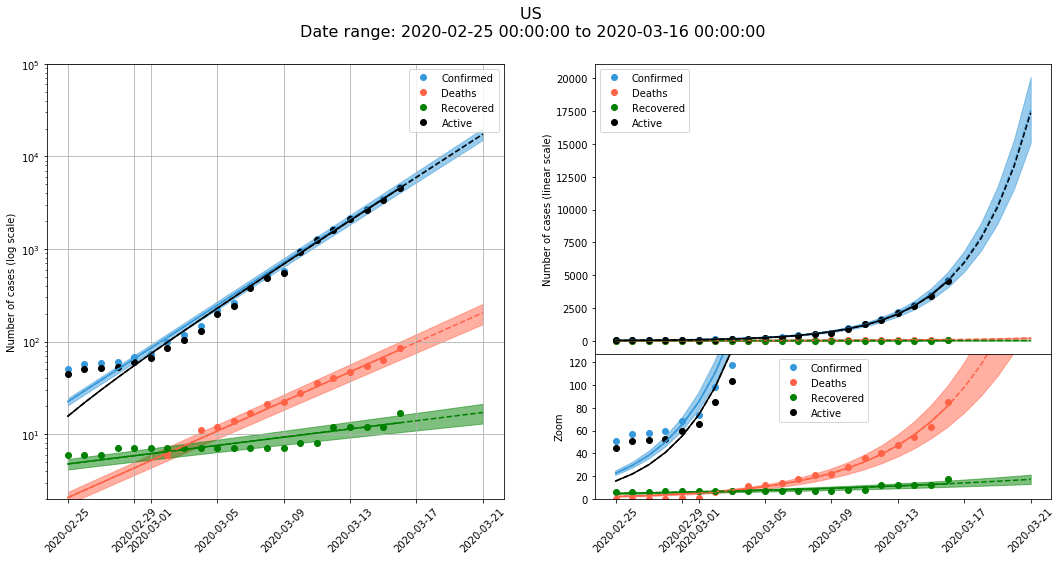

In [22]:
per_country = data.groupby(['DateTime','Country/Region']).sum().reset_index()
usa = per_country[per_country['Country/Region']=='US']
usa['Province/State'] = ''
min_y1 = {'Confirmed': 50, 'Deaths': 0, 'Recovered': 0}
print(type(usa['DateTime'].iloc[0]))
fits_todo1 = {'Confirmed': [func_exponential],
             'Deaths':     [func_exponential],
             'Recovered':  [func_exponential]}

my_country = select_country(usa, country='US', province='', start_date='2020-02-25')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_prediction(prediction, days=5)

# Comparison of different countries, with a manual time delay to align them

In [23]:
def compare_countries2(data, countries, lw1=4, name='comparison'):
    gridsize = (3, 2)
    fig = plt.figure(figsize=(20, 16))
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (2, 0))
    #ax4 = plt.subplot2grid(gridsize, (3, 0))
    ax1b = plt.subplot2grid(gridsize, (0, 1))
    ax2b = plt.subplot2grid(gridsize, (1, 1))
    ax3b = plt.subplot2grid(gridsize, (2, 1))
    #ax4b = plt.subplot2grid(gridsize, (3, 1))
    plt.subplots_adjust(hspace=0)

    for country in countries.keys():
        c = countries[country]
        my_country = select_country(data,
                                    country=c['country'],
                                    province=c.get('province', ''),
                                    start_date=c.get('start_date', '2020-02-15'),
                                    end_date=c.get('end_date', '2021-01-01'))
        data_country1, prediction1 = fit_data(my_country)

        symbol='x'
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol)
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color())
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol)
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color())
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol)
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color())
        
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol)
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color())
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol)
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color())
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol)
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color())
       
        
    #ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    #ax1.set_ylim(0.5,1e5)

    ax1.set_ylabel('Confirmed')
    ax2.set_ylabel('Deaths')
    ax3.set_ylabel('Recovered')
    
    for ax in [ax1,ax2,ax1b,ax2b]:
        ax.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax3b.xaxis.set_tick_params(rotation=45)
    ax1.set_title('Log scale')
    ax1b.set_title('Linear scale')
    #fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)

    for ax in [ax1,ax2,ax3]:
        ax.set_yscale('log')
    
    for ax in [ax1,ax2,ax3,ax1b,ax2b,ax3b]:
        ax.set_ylim(0.5,)
        ax.legend()
        
    fig.savefig(f'./plots/{name}.png', bbox_inches='tight', dpi=150)
        

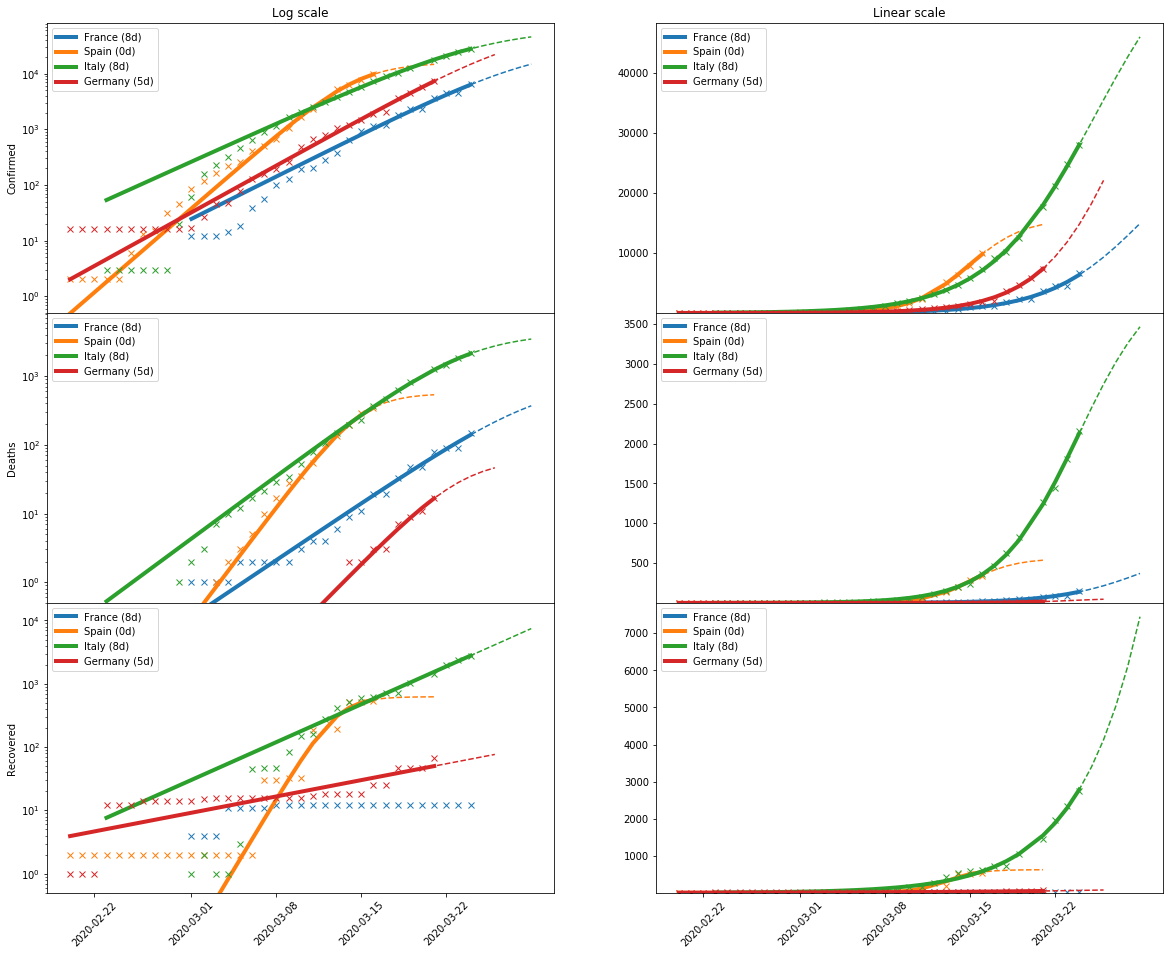

In [24]:
countries = {
    'France': {'country': 'France', 'province': 'France', 'start_date':'2020-02-22', 'end_date':'2021-01-01', 'delay': 8},
    'Spain': {'country': 'Spain', 'start_date':'2020-02-20', 'end_date':'2021-01-01', 'delay': 0},
    'Italy': {'country': 'Italy', 'start_date':'2020-02-15', 'end_date':'2021-01-01', 'delay': 8},
    'Germany': {'country': 'Germany', 'start_date':'2020-02-15', 'end_date':'2021-01-01', 'delay': 5},

}
compare_countries2(data, countries, name='comparison1')

## Early onset: China regions

Most of the regions have almost completed the cycle and active cases are disappearing. Note that China Hubei (the original area) has a large number of confirmed cases (70000), but the other regions have very low number of cases, with number around 1200-500 or even less.

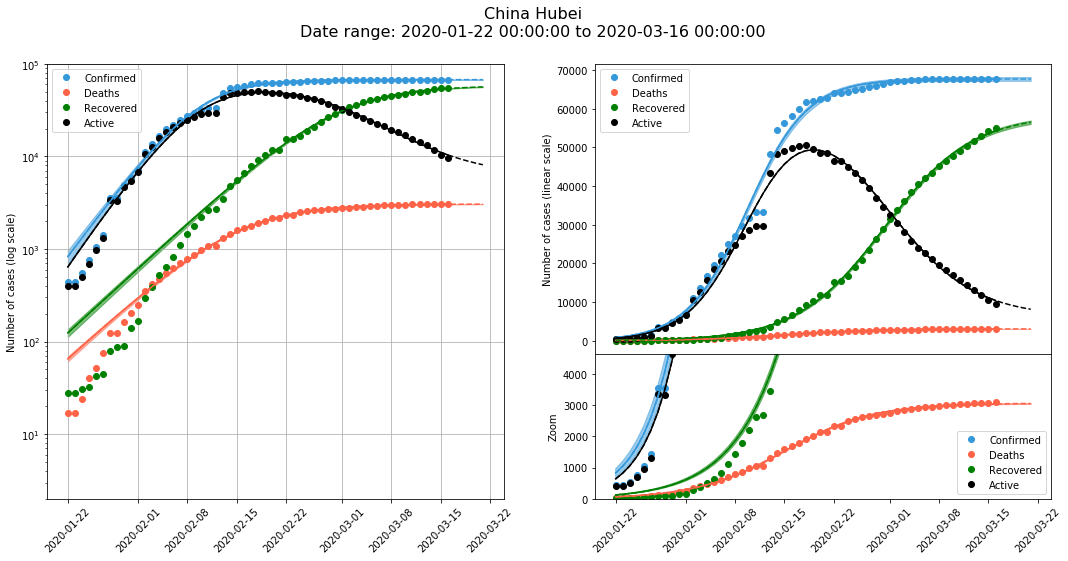

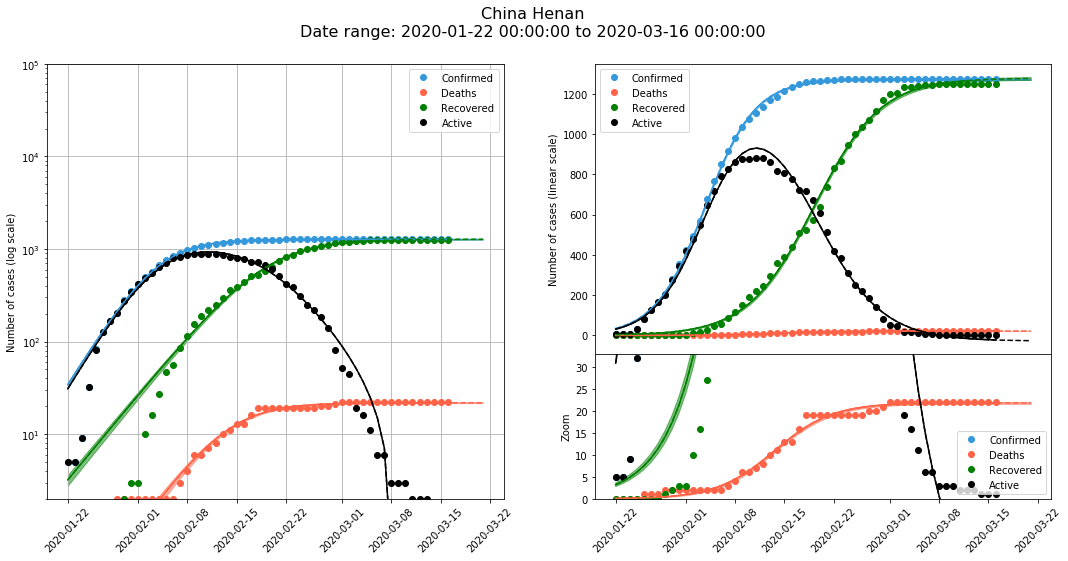

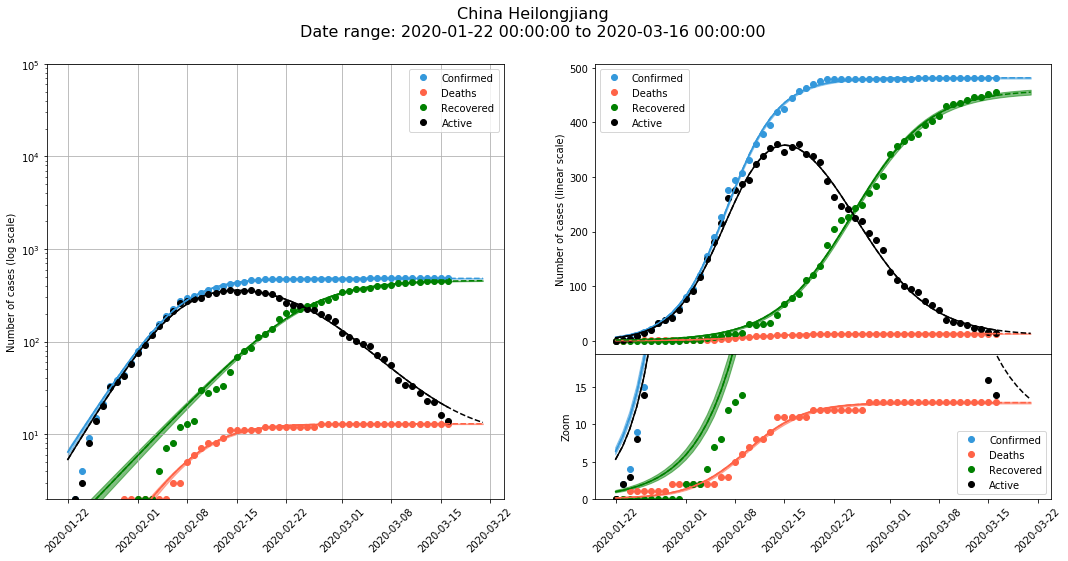

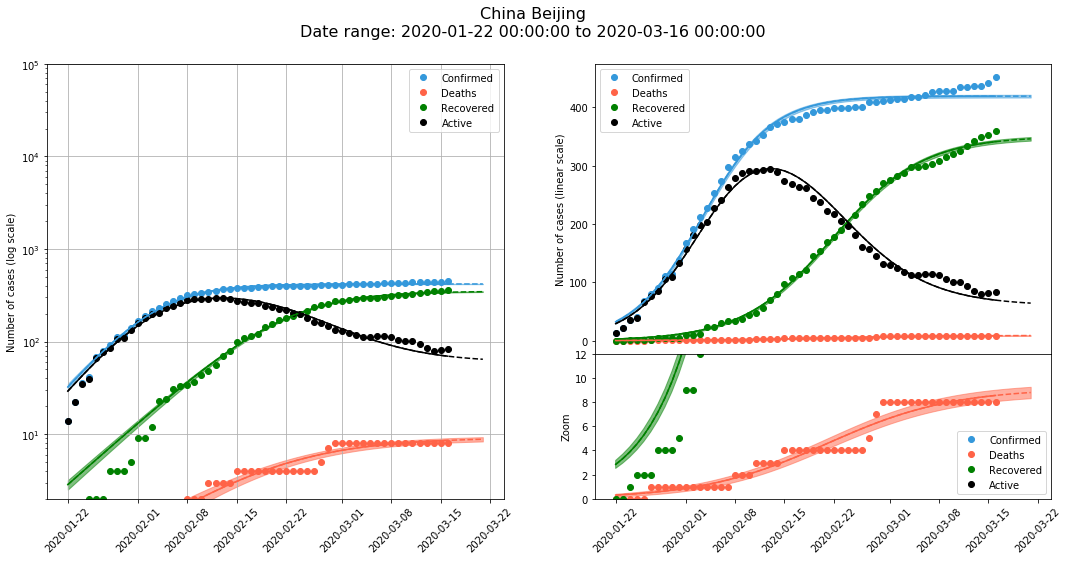

In [25]:
idx = data.groupby(['Country/Region', 'Province/State'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:10].index
for i in idx:
    country, province = i
    if country == 'China':
        data_country, prediction, fig, ax = process_country(data, country=country, province=province, start_date='2020-01-01')

## Other countries in Asia

South Korea has a remarkable recovery rate, with many cases and a reduced number of deaths. Japan growth is moderate, much smaller than in European countries. Iran is showing hints of flattening, although it is curious that the number of recoveries has significantly slowed down while the number of deaths still follow a very exponential trend.


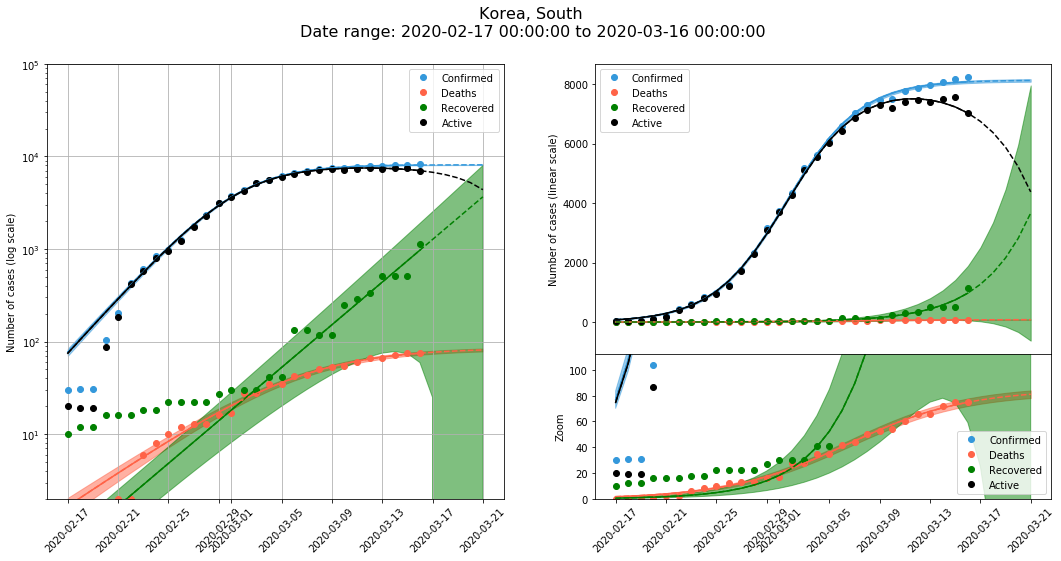

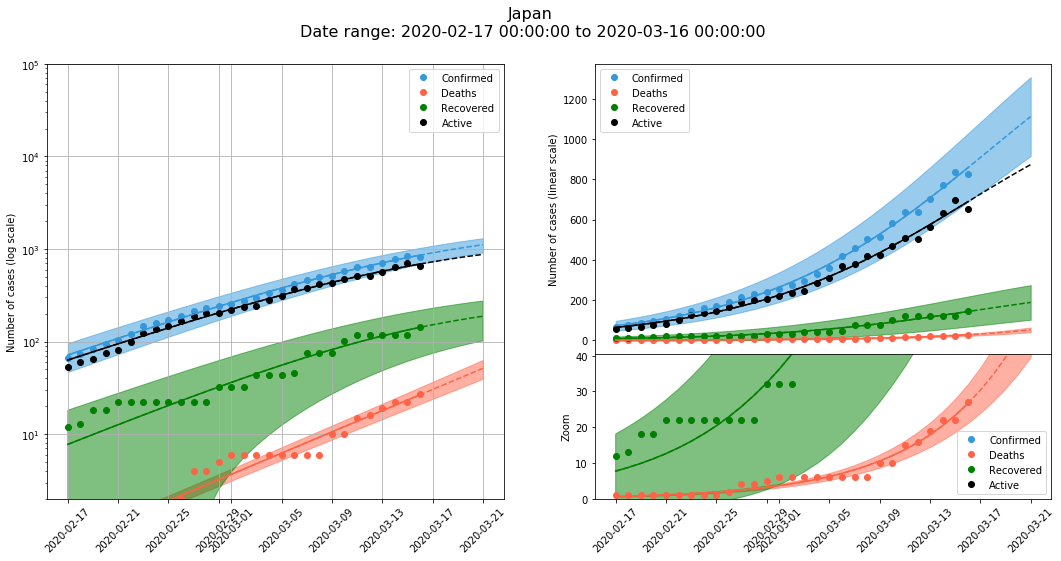

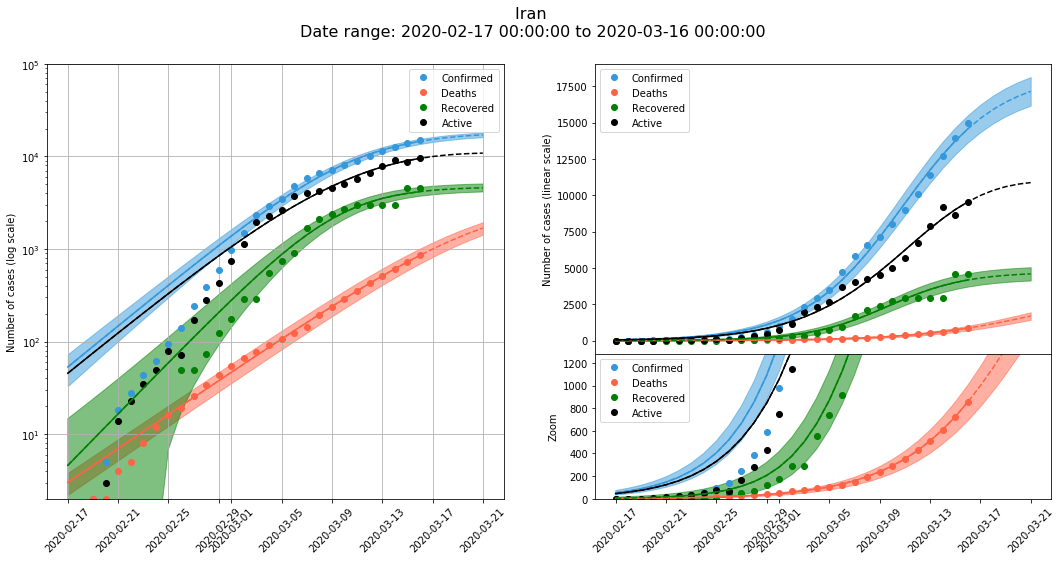

In [26]:
europe_list = [
    ['Korea, South', ''],
    ['Japan', ''],
    ['Iran', '']
]
for country, province in europe_list:
    data_country, prediction, fig, ax = process_country(data, country=country, province=province, start_date='2020-02-17')